# Figure 2: Evidence for a Multi-Phase CGM

In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
# from matplotlib import cm as cmapper

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle
from scipy.stats import norm


In [2]:
# Load Full Data
full_ideal_res = QTable.read("Data/Full_Ideal_CloudyResults_wNHII.fits")

# Load High Ion Results
with open("Data/HIGH_ION_DATA_wHII.pkl", "rb") as f:
    high_ion_data = pickle.load(f)

### Cloudy Models

In [3]:
# Observed Column Residuals
CII_obs_cloudy = full_ideal_res["MEAS_N_CII"]/full_ideal_res["N_CII"]
SiII_obs_cloudy = full_ideal_res["MEAS_N_SiII"]/full_ideal_res["N_SiII"]
AlII_obs_cloudy = full_ideal_res["MEAS_N_AlII"]/full_ideal_res["N_AlII"]
CIV_obs_cloudy = full_ideal_res["MEAS_N_CIV"]/full_ideal_res["N_CIV"]
SiIV_obs_cloudy = full_ideal_res["MEAS_N_SiIV"]/full_ideal_res["N_SiIV"]

/Users/dk/anaconda3/envs/voigt/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [4]:
# Normalized Column Residuals
CII_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_CII"].value)-np.log10(full_ideal_res["N_CII"].value))/(1/np.log(10) * 
                                                                                                             np.log10(full_ideal_res["MEAS_ERR_N_CII"].value)/
                                                                                                             np.log10(full_ideal_res["MEAS_N_CII"].value))

SiII_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_SiII"].value)-np.log10(full_ideal_res["N_SiII"].value))/(1/np.log(10) * 
                                                                                                             np.log10(full_ideal_res["MEAS_ERR_N_SiII"].value)/
                                                                                                             np.log10(full_ideal_res["MEAS_N_SiII"].value))


AlII_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_AlII"].value)-np.log10(full_ideal_res["N_AlII"].value))/(1/np.log(10) * 
                                                                                                             np.log10(full_ideal_res["MEAS_ERR_N_AlII"].value)/
                                                                                                             np.log10(full_ideal_res["MEAS_N_AlII"].value))

CIV_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_CIV"].value)-np.log10(full_ideal_res["N_CIV"].value))/(1/np.log(10) * 
                                                                                                             np.log10(full_ideal_res["MEAS_ERR_N_CIV"].value)/
                                                                                                             np.log10(full_ideal_res["MEAS_N_CIV"].value))

SiIV_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_SiIV"].value)-np.log10(full_ideal_res["N_SiIV"].value))/(1/np.log(10) * 
                                                                                                             np.log10(full_ideal_res["MEAS_ERR_N_SiIV"].value)/
                                                                                                             np.log10(full_ideal_res["MEAS_N_SiIV"].value))



CII_obs_cloudy_sig_masked = np.ma.masked_array(CII_obs_cloudy_sig, mask = full_ideal_res["MEAS_ERR_N_CII"].value == -1)
SiII_obs_cloudy_sig_masked = np.ma.masked_array(SiII_obs_cloudy_sig, mask = full_ideal_res["MEAS_ERR_N_SiII"].value == -1)
AlII_obs_cloudy_sig_masked = np.ma.masked_array(AlII_obs_cloudy_sig, mask = full_ideal_res["MEAS_ERR_N_AlII"].value == -1)

CIV_obs_cloudy_sig_masked = np.ma.masked_array(CIV_obs_cloudy_sig, mask = (full_ideal_res["MEAS_ERR_N_CIV"].value == -1)|np.isinf(CIV_obs_cloudy_sig))

SiIV_obs_cloudy_sig_masked = np.ma.masked_array(SiIV_obs_cloudy_sig, mask = (full_ideal_res["MEAS_ERR_N_SiIV"].value == -1)|np.isinf(CIV_obs_cloudy_sig))



<ipython-input-4-ef1a09f0ca1d>:3: RuntimeWarning: invalid value encountered in log10
  np.log10(full_ideal_res["MEAS_ERR_N_CII"].value)/
<ipython-input-4-ef1a09f0ca1d>:7: RuntimeWarning: invalid value encountered in log10
  np.log10(full_ideal_res["MEAS_ERR_N_SiII"].value)/
<ipython-input-4-ef1a09f0ca1d>:12: RuntimeWarning: invalid value encountered in log10
  np.log10(full_ideal_res["MEAS_ERR_N_AlII"].value)/
<ipython-input-4-ef1a09f0ca1d>:15: RuntimeWarning: divide by zero encountered in log10
  CIV_obs_cloudy_sig = (np.log10(full_ideal_res["MEAS_N_CIV"].value)-np.log10(full_ideal_res["N_CIV"].value))/(1/np.log(10) *
<ipython-input-4-ef1a09f0ca1d>:16: RuntimeWarning: invalid value encountered in log10
  np.log10(full_ideal_res["MEAS_ERR_N_CIV"].value)/
<ipython-input-4-ef1a09f0ca1d>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(full_ideal_res["MEAS_ERR_N_SiIV"].value)/


### Temperature Distributions


In [5]:

data_temp = {}

logt = np.ma.masked_array(data = full_ideal_res["RATIO_LOGT_FIRST"].newbyteorder().byteswap())
logt.mask = np.isnan(logt)
logt.mask = np.isinf(logt)
logt.mask = logt < 2

data_temp["CIE"] = logt

# sns.kdeplot(logt ,ax = ax, label = "CIE", color = pal[7], alpha = 0.4, shade = True, lw = 2)

logt2 = np.ma.masked_array(data = full_ideal_res["RATIO_LOGT_ISOB"].newbyteorder().byteswap())
logt2.mask = np.isnan(logt2)
logt2.mask = np.isinf(logt2)
logt2.mask = logt2 < 2

data_temp["Isobaric"] = logt2

# sns.kdeplot(logt ,ax = ax, label = "Isobaric", color = pal[9], alpha = 0.4, shade = True, lw = 2)

logt3 = np.ma.masked_array(data = full_ideal_res["RATIO_LOGT_ISOCh"].newbyteorder().byteswap())
logt3.mask = np.isnan(logt3)
logt3.mask = np.isinf(logt3)
logt3.mask = logt3 < 2

data_temp["Isochoric"] = logt3

logt4 = np.ma.masked_array(data = np.log10(full_ideal_res["Te"].value.newbyteorder().byteswap()))
logt4.mask = np.isnan(logt4)
logt4.mask = np.isinf(logt4)
logt4.mask = logt4 < 2

data_temp["Photoionized"] = logt4


# Calculate median temperature with errors
tdp = np.percentile(logt[~logt.mask],(16,50,84))
t,tp,tn = tdp[1],tdp[2]-tdp[1],tdp[1]-tdp[0]

tdp2 = np.percentile(logt2[~logt2.mask],(16,50,84))
t2,tp2,tn2 = tdp2[1],tdp2[2]-tdp2[1],tdp2[1]-tdp2[0]

tdp3 = np.percentile(logt3[~logt3.mask],(16,50,84))
t3,tp3,tn3 = tdp3[1],tdp3[2]-tdp3[1],tdp3[1]-tdp3[0]

tdp4 = np.percentile(logt4[~logt4.mask],(16,50,84))
t4,tp4,tn4 = tdp4[1],tdp4[2]-tdp4[1],tdp4[1]-tdp4[0]

data_temp_master2 = {r"$\log_{10}(T/K)$":np.ma.concatenate([data_temp["CIE"], 
                                                        data_temp["Isochoric"], 
                                                        data_temp["Photoionized"]]),
                   "Ionization Model":np.concatenate([[r"Equilibrium: $\log_{{10}}(T_e) = {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(t,tp,tn)]*len(data_temp["CIE"]), 
                                           [r"Nonequilibrium: $\log_{{10}}(T_e) = {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(t3,tp3,tn3)]*len(data_temp["Isochoric"]),
                                                     [r"Photoionized: $\log_{{10}}(T_e) = {0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}$".format(t4,tp4,tn4)]*len(data_temp["Photoionized"]),])}


### Line Widths

In [6]:
masked_CIV_b = np.ma.masked_array(full_ideal_res["B_CIV"].value, 
                                  mask = (np.isnan(full_ideal_res["B_CIV"]) | 
                                          (full_ideal_res["ERR_B_CIV"] > .5 * full_ideal_res["B_CIV"]))).newbyteorder().byteswap() 

masked_CIV_b_err = np.ma.masked_array(full_ideal_res["ERR_B_CIV"].value, 
                                  mask = (np.isnan(full_ideal_res["B_CIV"]) | 
                                          (full_ideal_res["ERR_B_CIV"] > .5 * full_ideal_res["B_CIV"]))).newbyteorder().byteswap() 

masked_CII_b = np.ma.masked_array(full_ideal_res["B_CII"].value, 
                                  mask = (np.isnan(full_ideal_res["B_CII"]) | 
                                          (full_ideal_res["ERR_B_CII"] > .5 * full_ideal_res["B_CII"]))).newbyteorder().byteswap() 

masked_CII_b_err = np.ma.masked_array(full_ideal_res["ERR_B_CII"].value, 
                                  mask = (np.isnan(full_ideal_res["B_CII"]) | 
                                          (full_ideal_res["ERR_B_CII"] > .5 * full_ideal_res["B_CII"]))).newbyteorder().byteswap() 

masked_SiIV_b = np.ma.masked_array(full_ideal_res["B_SiIV"].value, 
                                  mask = (np.isnan(full_ideal_res["B_SiIV"]) | 
                                          (full_ideal_res["ERR_B_SiIV"] > .5 * full_ideal_res["B_SiIV"]))).newbyteorder().byteswap() 

masked_SiIV_b_err = np.ma.masked_array(full_ideal_res["ERR_B_SiIV"].value, 
                                  mask = (np.isnan(full_ideal_res["B_SiIV"]) | 
                                          (full_ideal_res["ERR_B_SiIV"] > .5 * full_ideal_res["B_SiIV"]))).newbyteorder().byteswap() 

masked_SiII_b = np.ma.masked_array(full_ideal_res["B_SiII"].value, 
                                  mask = (np.isnan(full_ideal_res["B_SiII"]) | 
                                          (full_ideal_res["ERR_B_SiII"] > .5 * full_ideal_res["B_SiII"]))).newbyteorder().byteswap() 

masked_SiII_b_err = np.ma.masked_array(full_ideal_res["ERR_B_SiII"].value, 
                                  mask = (np.isnan(full_ideal_res["B_SiII"]) | 
                                          (full_ideal_res["ERR_B_SiII"] > .5 * full_ideal_res["B_SiII"]))).newbyteorder().byteswap() 

masked_OVI_b = np.ma.masked_array(full_ideal_res["B_OVI"], 
                                  mask = (np.isnan(full_ideal_res["B_OVI"]) | 
                                          (full_ideal_res["ERR_B_OVI"] > .5 * full_ideal_res["B_OVI"]))).newbyteorder().byteswap() 

## Figure 2

In [7]:
resid_data = {"resid":np.ma.concatenate([CII_obs_cloudy_sig_masked,
                                         SiII_obs_cloudy_sig_masked, 
                                         AlII_obs_cloudy_sig_masked, 
                                         CIV_obs_cloudy_sig_masked,
                                         SiIV_obs_cloudy_sig_masked]),
              "Ion":np.concatenate([["CII"]*len(CII_obs_cloudy_sig_masked), 
                                    ["SiII"]*len(SiII_obs_cloudy_sig_masked), 
                                    ["AlII"]*len(AlII_obs_cloudy_sig_masked),
                                    ["CIV"]*len(CIV_obs_cloudy_sig_masked),
                                    ["SiIV"]*len(SiIV_obs_cloudy_sig_masked)])}

<IPython.core.display.Javascript object>


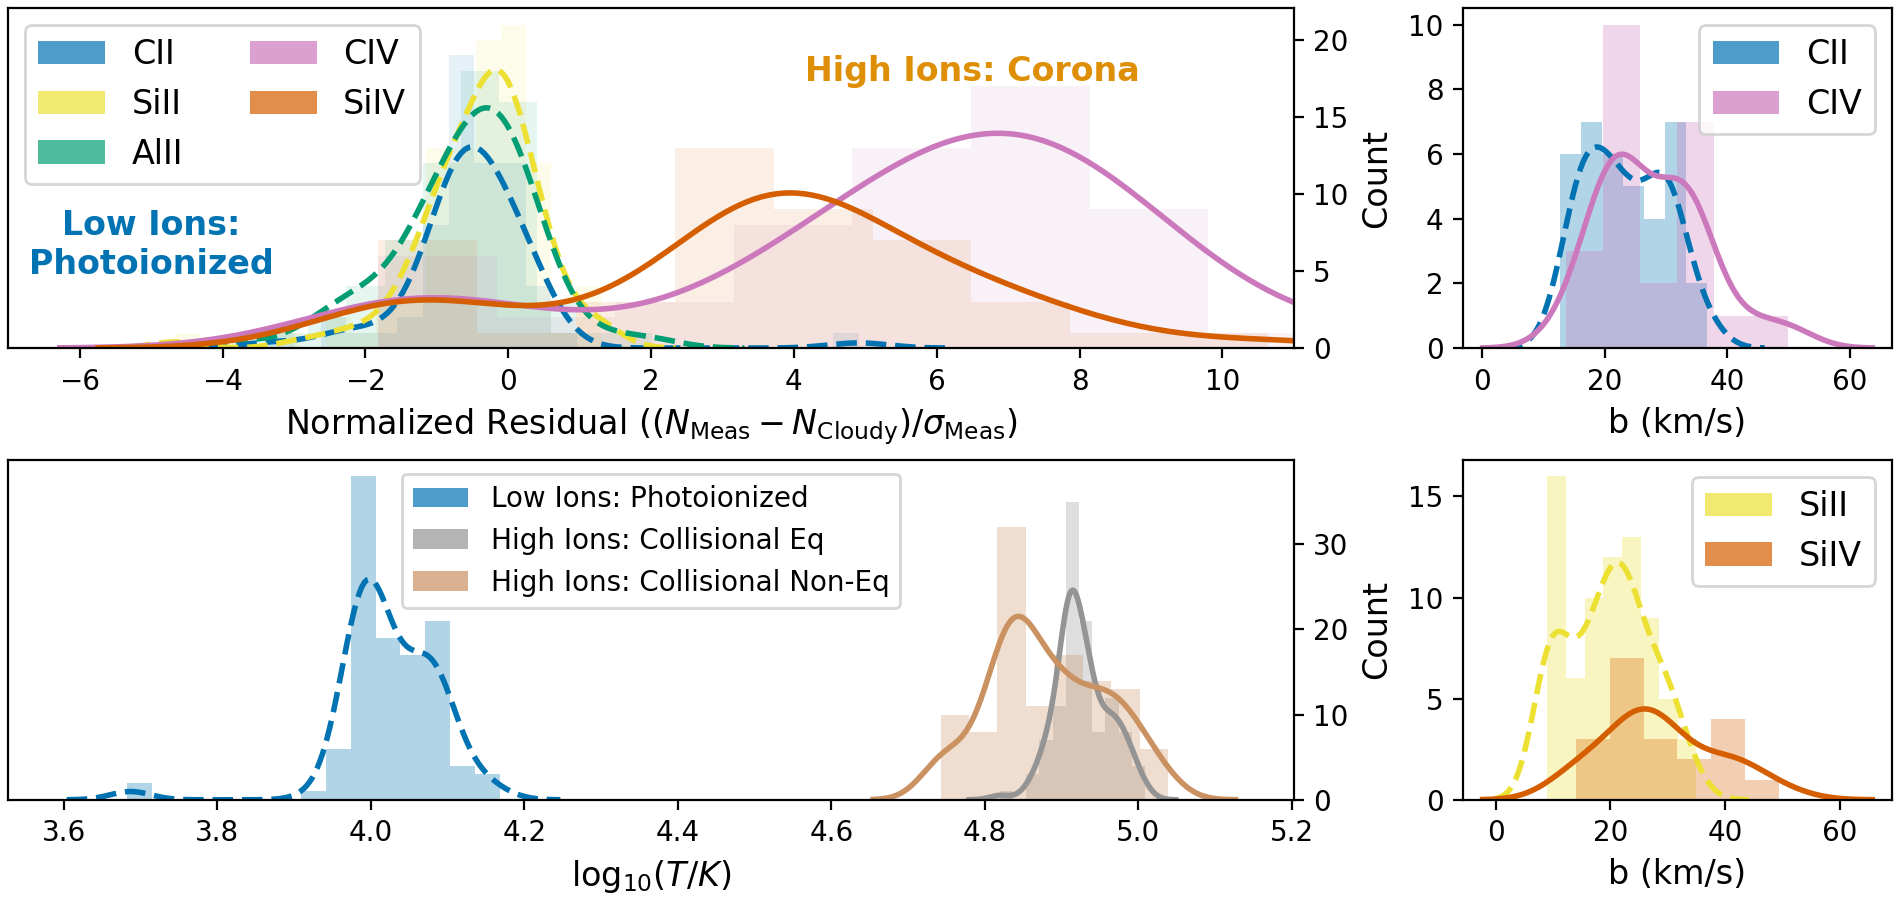

In [13]:

fig = plt.figure(constrained_layout=True, figsize = (9.5,4.5))
mosaic = """
    AAAB
    DDDC
"""
axs = fig.subplot_mosaic(mosaic)



# fig,ax = plt.subplots()
ax = axs["A"]

sns.histplot(x = CII_obs_cloudy_sig_masked, color = pal[0], alpha = 0.1, kde = True, stat = "count",
            label = "CII", ax = ax, 
             fill = True, lw = 0, kde_kws = {"cut":3})

sns.histplot(x = SiII_obs_cloudy_sig_masked, color = pal[8], alpha = 0.1, kde = True, stat = "count",
            label = "SiII", ax = ax, 
             fill = True, lw = 0, kde_kws = {"cut":3})


sns.histplot(x = AlII_obs_cloudy_sig_masked, color = pal[2], alpha = 0.1, kde = True, stat = "count",
            label = "AlII", ax = ax, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in ax.lines] 



sns.histplot(x = CIV_obs_cloudy_sig_masked, color = pal[4], alpha = 0.1, kde = True, stat = "count",
            label = "CIV", ax = ax, 
             fill = True, lw = 0, kde_kws = {"cut":3})


sns.histplot(x = SiIV_obs_cloudy_sig_masked, color = pal[3], alpha = 0.1, kde = True, stat = "count",
            label = "SiIV", ax = ax, 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth(2) for line in ax.lines] 

# sns.kdeplot(x=CII_obs_cloudy_sig_masked, ax = ax, color = pal[0], alpha = 0.3, label = "CII", 
#             lw = 2, shade = True, ls = "--")
# sns.kdeplot(x=SiII_obs_cloudy_sig_masked, ax = ax, color = pal[8], alpha = 0.3, label = "SiII", 
#             lw = 2, shade = True, ls = "--")
# sns.kdeplot(x=AlII_obs_cloudy_sig_masked, ax = ax, color = pal[2], alpha = 0.3, label = "AlII", 
#             lw = 2, shade = True, ls = "--")

# sns.kdeplot(x=CIV_obs_cloudy_sig_masked, ax = ax, color = pal[4], alpha = 0.3, label = "CIV", 
#             lw = 2, shade = True, ls = "-")
# sns.kdeplot(x=SiIV_obs_cloudy_sig_masked, ax = ax, color = pal[3], alpha = 0.3, label = "SiIV", 
#             lw = 2, shade = True, ls = "-")

xlim = ax.set_xlim(-7,11)




lg = ax.legend(fontsize = 12, ncol = 2)

for lh in lg.legendHandles: 
    lh.set_alpha(0.7)
# 

# ax.axvline(2, color = "k", ls = "--", lw = 2)

ax.text(6.5,19,"High Ions: Corona", fontsize = 12, fontweight = "bold", color = pal[1],
        ha = "center", va = "top")
# # ax.arrow(1.75,0.46,5,0, head_width = .02, head_length = .5, color = "k")

ax.text(-5,9,"Low Ions:\nPhotoionized", ha = "center", va = "top", 
        fontsize = 12, color = pal[0], fontweight = "bold")

ax.set_xlabel(r"Normalized Residual ($(N_\mathrm{Meas} - N_\mathrm{Cloudy})/\sigma_\mathrm{Meas}$)", 
              fontsize = 12)

ax.set_ylabel("Count", fontsize = 12)



# sns.histplot(data = data_temp_master2, x = r"$\log_{10}(T/K)$", hue = "Ionization Model", 
#             palette = [pal[7], pal[5], pal[0]], alpha = 0.4, lw = 1, kde = True, 
#              stat = "probability", binwidth = 0.05, line_kws = {"lw":2}, ax = axs["D"])

# tkde = sns.kdeplot(data = data_temp_master2, x = r"$\log_{10}(T/K)$", hue = "Ionization Model", 
#             palette = [pal[7], pal[5], pal[0]], alpha = 0.4, 
#              ax = axs["D"], lw = 2, shade = True, legend = False)

# sns.kdeplot(x = data_temp["CIE"], color = pal[7], shade = True, ls = "-", lw = 2, alpha = 0.3, 
#             label = "High Ions: Colissional Equilibrium", ax = axs["D"])



sns.histplot(x = data_temp["Photoionized"], color = pal[0], alpha = 0.3, kde = "True", stat = "count",
            label = "Low Ions: Photoionized", ax = axs["D"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in axs["D"].lines] 

sns.histplot(x = data_temp["CIE"], color = pal[7], alpha = 0.3, kde = True, stat = "count",
            label = "High Ions: Collisional Eq", ax = axs["D"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

sns.histplot(x = data_temp["Isochoric"], color = pal[5], alpha = 0.3, kde = "True", stat = "count",
            label = "High Ions: Collisional Non-Eq", ax = axs["D"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth(2) for line in axs["D"].lines] 
# sns.kdeplot(x = data_temp["Isochoric"], color = pal[5], shade = True, ls = "-", lw = 2, alpha = 0.3, 
#             label = "High Ions: Colissional Nonequilibrium", ax = axs["D"])

# sns.kdeplot(x = data_temp["Photoionized"], color = pal[0], shade = True, ls = "--", lw = 2, alpha = 0.3, 
#             label = "Low Ions: Photoionized", ax = axs["D"])

leg = axs["D"].legend(loc = "best")
for lh in leg.legendHandles: 
    lh.set_alpha(0.7)
# axs["D"].set_ylim(0,0.6)

# axs["D"].legend(labels = ['Low Ions: Photoionized',
#                           'High Ions: Colissional Nonequilibrium',
#                           'High Ions: Colissional Equilibrium'], 
#                 title = "Ionization Model", bbox_to_anchor = (0.81,1))

# sns.kdeplot(data = data_temp_master, x = r"$\log_{10}(T/K)$", hue = "Colissional Model", 
#             palette = [pal[7], pal[6], pal[5]], alpha = 0.4, lw = 1, shade = True, 
#             multiple = "layer")

axs["D"].set_xlabel(r"$\log_{10}(T/K)$", fontsize = 12)
axs["D"].set_ylabel("Count", fontsize = 12)


# sns.kdeplot(x= masked_SiII_b, color = pal[8], ax = axs["C"], 
#             shade = True, ls = "--", lw = 2, label = "SiII")
# sns.kdeplot(x= masked_SiIV_b, color = pal[3], ax = axs["C"], 
#             shade = True, lw = 2, label = "SiIV")

# axs["C"].legend(fontsize = 12)

sns.histplot(x = masked_SiII_b, color = pal[8], 
             alpha = 0.3, kde = "True", stat = "count",
            label = "SiII", ax = axs["C"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in axs["C"].lines] 

sns.histplot(x = masked_SiIV_b, color = pal[3], 
             alpha = 0.3, kde = "True", stat = "count",
            label = "SiIV", ax = axs["C"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth("2") for line in axs["C"].lines] 


leg = axs["C"].legend(fontsize = 12)

for lh in leg.legendHandles: 
    lh.set_alpha(0.7)

sns.histplot(x = masked_CII_b, color = pal[0], 
             alpha = 0.3, kde = "True", stat = "count",
            label = "CII", ax = axs["B"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linestyle("--") for line in axs["B"].lines] 

sns.histplot(x = masked_CIV_b, color = pal[4], 
             alpha = 0.3, kde = "True", stat = "count",
            label = "CIV", ax = axs["B"], 
             fill = True, lw = 0, kde_kws = {"cut":3})

[line.set_linewidth("2") for line in axs["B"].lines] 



leg = axs["B"].legend(fontsize = 12)
for lh in leg.legendHandles: 
    lh.set_alpha(0.7)

for ax in [axs["B"],axs["C"]]:
#     ax.set_ylabel("Probability", fontsize = 12)
#     ax.yaxis.tick_right()
    ax.set_ylabel(None)
    ax.set_xlabel("b (km/s)", fontsize = 12)
    
for ax in [axs["A"],axs["D"]]:
#     ax.set_ylabel("Probability", fontsize = 12)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")




In [107]:
np.unique(data_temp_master2["Ionization Model"])

array(['Equilibrium: $\\log_{10}(T_e) = 4.92^{+0.05}_{-0.02}$',
       'Nonequilibrium: $\\log_{10}(T_e) = 4.87^{+0.09}_{-0.06}$',
       'Photoionized: $\\log_{10}(T_e) = 4.02^{+0.07}_{-0.04}$'],
      dtype='<U55')